![McLaren Maze Race Banner](media/banner.png)

# Welcome to Pro Driver - level 4 of the McLaren Maze Race!

This level is all about grip, as we introduce tyres, aerodynamics, and rain. From an AI point-of-view we will look at time series forecasting and *latent variable modelling* - dealing with variables you can't measure.

Grip is the most important parameter in Formula 1 (although our reliability engineers might dispute that, afterall a broken car wins no races). You can have the most powerful engine on the grid but grip is what allows that power to be turned into acceleration and your driver to keep the power on in the corners. In our Maze Race grip is applied as a multiplier to both the speed deltas obtained when you apply a throttle or braking action and the maximum speed you can corner at. Hence, a high grip level will allow you to accelerate faster, brake later, and corner faster than a low grip level. 

The figure below shows the effect of grip on a straight of length 15. At each point along the straight we compute the maximum speed that the car can achieve given it starts from stationary and needs to safely make it round the corner.

![A sweep of grip values on a straight](media/grip_sweep.png)

We can see how the car is able to reach maximum speed for much of the straight when the grip level is high and how this drops away as the grip lowers. The plot on the right shows the effect on the race time for this straight relative to a grip of 1.0. Initially the driver doesn't lose too much time but as the grip gets towards its lowest levels the amount of time lost becomes much more serious.

In this level we will carry forward the AI we designed in the previous level and extend it to cope with the varying levels of grip that it comes across. Recall that the heart of our AI driver was the dynamics model it learnt, which predicted what the next car speed would be given the current speed and a particular action to be taken. Previously, the change in car speed was only affected by these two parameters but now we have to take the grip level into account. As a first step towards this we are going to switch from modelling the next speed directly to modelling the change in speed, as we are told above the grip is applied as a multiplier to the speed delta. Our model is now,

<div align="center"> 
    next speed = current speed + <i>f</i> ( current speed, action ) * grip
</div>

where *f* is the dynamics model the AI must learn from data. The major issue to tackle next is that the grip level is not always going to be known and so we will have to learn it from the data alongside the dynamics.

There are two major contributers to the car's grip level that we will explore in this level: the tyres, and the track state. We will start with tyres.
 
## Tyres

Tyres are the only thing that link our car to the track and hence are critical to a car's performance. The fundamental trade-off with tyres is grip versus life: a tyre can only provide its peak grip for so long before it starts to degrade. Just like in F1 in the Maze Race there are three different tyre compounds: Soft, Medium, and Hard. Soft has the most grip but the shortest life, and Hard has the lowest initial grip but a much more gentle degradation curve than the Soft tyre. We can plot a degradation curve for the tyres using the method shown below.

In [1]:
# Imports, need to run this cell first whenever the kernel restarts
from imports import *
%matplotlib widget

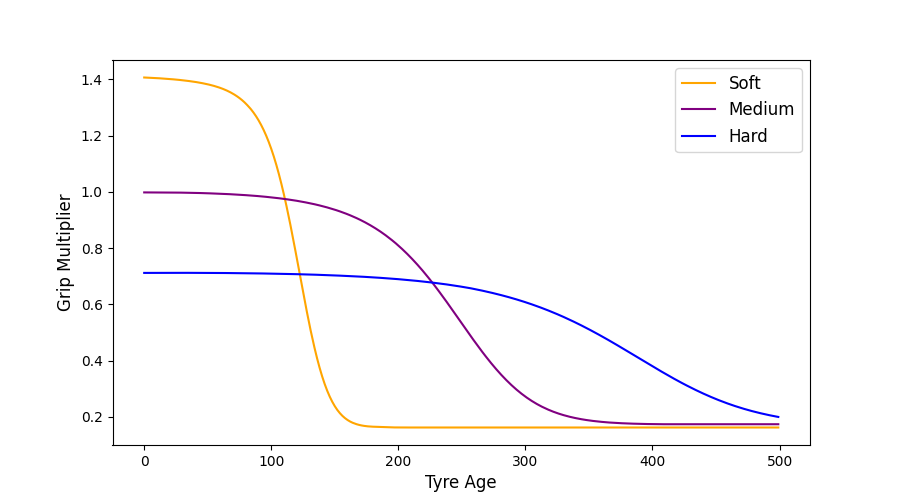

In [27]:
plot_tyre_degradation()

As well as the differences between compounds we can see that, after an initial gentle period of grip reuction, the tyres have a phase of steep performance loss. This is particularly pronounced in the Soft compound, which loses almost all its performance in ~50 moves. Keeping away from this cliff edge is likely to be important for a race winning strategy!

One of the challenges we face with tyres in F1 is that the tyre performance is not constant from track to track (or even hour-to-hour sometimes!). The tyre behaviour is affected by many aspects such as the track roughness and the tyre temperature. Hence, there is a level of randomness built into the tyres in the Maze Race. Each race the tyre behaviour will change by a small amount and so our driver will have to learn the effects of the tyre each race. To get an idea of how the tyres change, we can plot several tyre degradation curves.



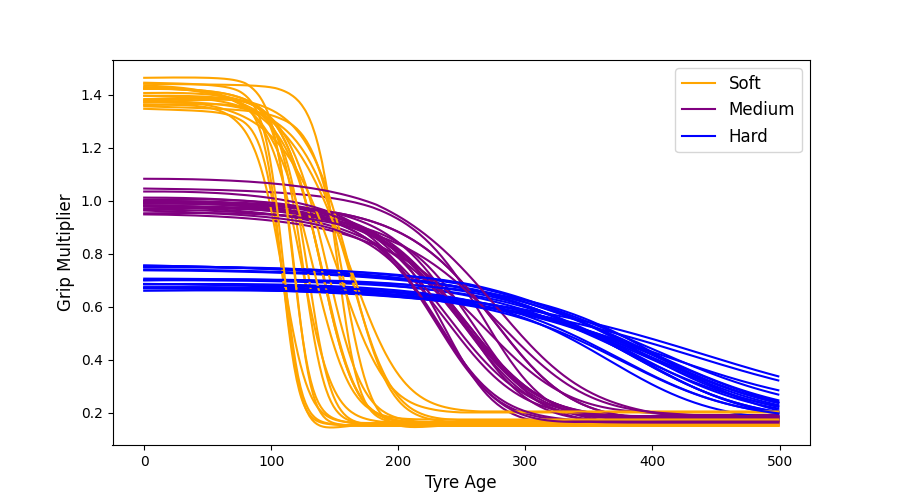

In [28]:
plot_tyre_degradation(20)

The curves all broadly follow the same shape but have some significant differences, especially if we need to know the point where the sharp loss in grip kicks in. 

### Pit Stops

In the Pro Driver level, each time the AI is asked to make a move, it is given a new piece of information in the form of the `TyreState`. This tells the AI what the current grip level of the tyre is. The first thing we can use this for is in the learning of the car dynamics model - recall that to learn the function *f* above we need to know what the grip level is. This means we can adjust our predictions of taking each action as the tyre grip degrades.

However, we aren't stuck with the tyre as its performance erodes; in this level we have a new action that our AI driver can take: `Action.ChangeTyres` - we can make a pit stop! As in F1, pit stops have a time penalty associated with them:

- To make a pit stop the driver must first bring the car to a halt. A `ChangeTyres` action will be ignored if car speed > 0 and a `Continue` action will be applied instead.
- Changing tyres takes one move after which the driver is free to accelerate again
- This means that the total time lost is 1 plus the time it takes to brake to a halt and accelerate again

With this in mind, our AI driver must choose whether it is faster to change tyres or push on to the end with the current set. This is similar to the DRS choice that was introduced in the previous level, and we will tackle it in a similar way: simulating our car's performance with the current tyres and with new tyres. For us to be able to do this though, we need to be able to predict how the tyre will behave for the rest of the race. This brings us to our first challenge relating to tyres: modelling the degradation.

### Modelling tyre degradation

Each turn our driver has the AI gets a new measurement of tyre grip. Our goal is to predict the tyre degradation curve for the current tyre given the set of measurements we have received. This problem is known as *time series forecasting* and finds applications in many areas of our lives. A popular algorithm for time series forecasting is known as an *autoregressive model*. This approach uses a weighted sum of previous samples to predict the next sample; for example, we might learn that the next sample is equal to -1 times the current sample plus 0.91 times the sample before that plus 1.1 times the sample before that (you might like to try and plot that sequence starting from [1, 1, 1]). 

This context is somewhat different to the usual time series setup, however. Rather than having a single time series stretching on into the future, we have multiple repeats of a short time series, each of which follows a similar path. Hence we will treat this more like an online regression (function estimation) problem. If we knew all the curves followed a particular equation (but with different parameter values) then we could fit the parameters of this equation to the data as it comes in. Unfortunately we don't have such an equation and don't even know if the curve actually follows any particular equation. We could still try this approach by choosing a family of functions that are close in shape to the observed data, for example we could pick a set of sigmoid shapes parameterised by,

<div align="center"> grip = a + b / (1 + exp(-c + age / d)) </div>

where a, b, c, and d are all parameters that we need to choose such that the curve fits the data best. There are two problems with this approach. Firstly, the accuracy will be limited by how close the true data is to the set of shapes that can be produced by the equation above. We could fit a curve to all the tyres we have data for and check that the fit is acceptable, but this doesn't guarantee that performance will be OK in the online challenge, which will have slightly different shapes. Secondly, the family of curves defined by the equation above is actually very broad - much broader than the true range of degradation curves. This means the model can produce a wide range of different shapes all of which fit the data but make wildly different forecasts, many of which are unrealistic. For example, suppose after the first 100 moves we have observed the grip values show by the red crosses below. There isn't much information to go on yet and so there are many different sigmoids that can fit the data, as shown by all the coloured lines below.

![Multiple sigmoid fits to tyre data](media/sigmoids.png)

We therefore need a way of restricting the potential curves much more tightly to those that are actually possible, such that are predictions are realistic. This means we have two things we want to learn simultaneously:
- the class of all possible tyre degradation curves - i.e. what do the curves usually look like
- the particular degradataion shape of the tyres currently on the car

This is a broad area of machine learning/AI with lots of potential solutions. It is particularly well suited to probabilistic modelling, which can provide bands of uncertainty that cover all likely fits to the observed data. We encourage you to explore this area for yourself! For now, we will stick with a simpler approach to save turning this into a degree course. 

The approach we will take is to use the curves that we record from previous races - afterall we will record the detailed shape of at least one tyre every race that we complete. A simple approach therefore would be to keep compiling all the different tyre curves we get each race and then use the average curve as our prediction for the next race:


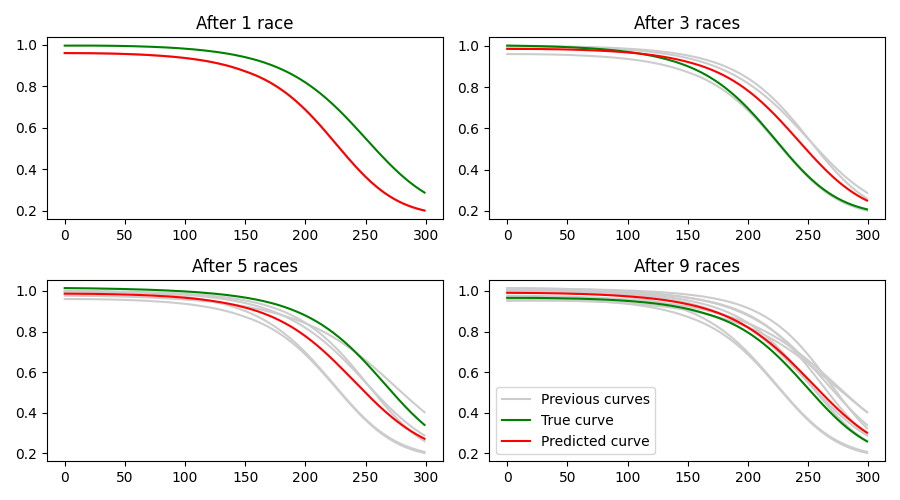

In [29]:
num_races = 10
x = np.arange(300)
grips = np.zeros((x.size, num_races))

# Sample a tyre curve for each race
set_seed(1)
for i in range(num_races):
    tyre_model = TyreModel()
    tyre_model.new_tyres_please(TyreChoice.Medium)
    grips[:, i] = tyre_model.get_grip(x)

# Use the mean
fig = plt.figure(figsize=(9, 5))
for i, n in enumerate([1, 3, 5, 9]):
    ax = fig.add_subplot(2, 2, i + 1)
    past_line = ax.plot(x, grips[:, :n], c=(0.8, 0.8, 0.8))[0]
    true_line = ax.plot(x, grips[:, n], c='g')[0]
    prediction_line = ax.plot(x, np.mean(grips[:, :n], axis=1), c='r')[0]
    ax.set_title(f'After {n} race{"s" if n > 1 else ""}')
ax.legend([past_line, true_line, prediction_line], ['Previous curves', 'True curve', 'Predicted curve'])
fig.tight_layout()

This isn't too bad but it does take a lot of races for the prediction to stabilise and it can still have quite large errors as the tyre curves can be quite far away from the mean. If we want to drive as fast as we can then we will always be on the edge of grip and so even a very small error in grip prediction can lead to the driver crashing. We also haven't made any use of the grip data we are receiving in the current race - the predicted curve is just the average of past race data. We can improve things by adapting the mean curve to the new data. The plot below shows what happens if we allow the mean to shift in both x and y, as we get more data.

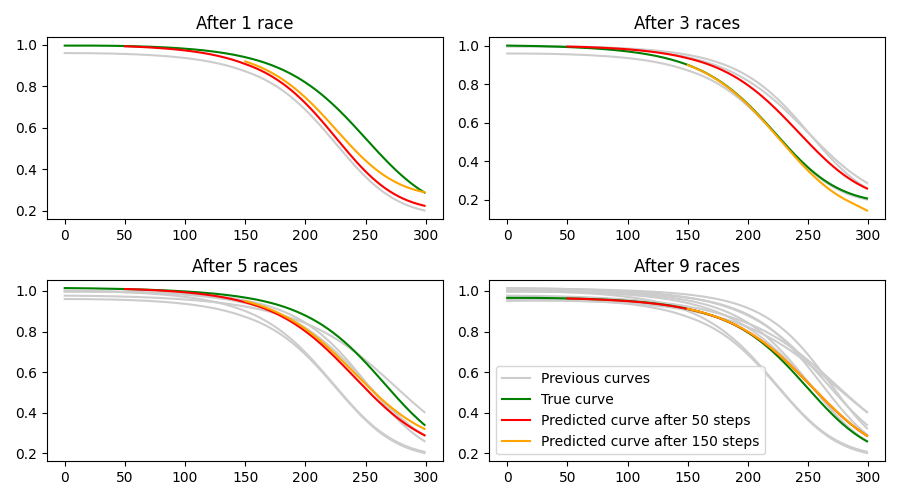

In [30]:
# This cell requires the ones before it to run
from scipy.optimize import minimize
from scipy.interpolate import interp1d

fig = plt.figure(figsize=(9, 5))
T = [50, 150]                 # make a prediction after this number of turns 
colours = ['r', 'orange']
def predict_tyre_grip(age, age_offset, grip_offset, grip_scale):
   return grip_scale * interp(age + age_offset) + grip_offset
def obj_fun(param):           # squared error between prediction and observed data up to time t
    return np.mean((grips[:t, n] - predict_tyre_grip(x[:t], *param))**2)
    
for i, n in enumerate([1, 3, 5, 9]):
    ax = fig.add_subplot(2, 2, i + 1)
    past_line = ax.plot(x, grips[:, :n], c=(0.8, 0.8, 0.8))[0]
    true_line = ax.plot(x, grips[:, n], c='g')[0]
    
    m = np.mean(grips[:, :n], axis=1)      # average curve from previous races
    interp = interp1d(x, m, kind='linear', fill_value='extrapolate')
    prediction_lines = []
    for ti, t in enumerate(T):
        p0 = [0, 0, 1]
        res = minimize(obj_fun, p0, bounds=[(-50, 50), (-0.1, 0.1), (0.9, 1.1)])
        prediction_lines += ax.plot(x[t:], predict_tyre_grip(x[t:], *res.x), c=colours[ti])
    ax.set_title(f'After {n} race{"s" if n > 1 else ""}')
    
ax.legend([past_line, true_line] + prediction_lines, 
          ['Previous curves', 'True curve'] + [f'Predicted curve after {t} steps' for t in T])

fig.tight_layout()

Let's implement this approach. Our ProDriver has code to store all the tyre data and compute the average degradation curve at the end of each race. During the next race we periodically estimate the offset parameters that make this curve look like the tyre data the driver is receiving. Let's watch this in progress. Below you can see the driver tackling a race and we have added an extra figure containing two plots. The top plot shows the tyre grip levels during the race as they degrade. The red line is our fitted model, predicting how the grip will change in the future. Each time we update the model we leave the old prediction shown in grey so you can see how the estimate varies over the race. Ideally, all the lines look very similar.

The second axes shows how the driver uses the predicted grips at the start of a straight to adapt the targeted speed profile. As the grip levels drop the driver cannot accelerate, brake, or corner particularly fast. At low grip levels the AI learns to gently ease the car around the track to avoid crashing - and mostly suceeds. When it does crash this is usually because it has predicted a too high level of grip and so ends up travelling too fast at the end of the straight - when the corner approaches the driver suddenly finds the car can't stop as fast as it predicted! To help avoid this we have added a fixed safety margin: the AI actually uses only 95% of the predicted grip when calculating the target speeds to allow for error. A better approach would be to learn what the uncertainty in the predictions actually is and adapt the target speeds accordingly...

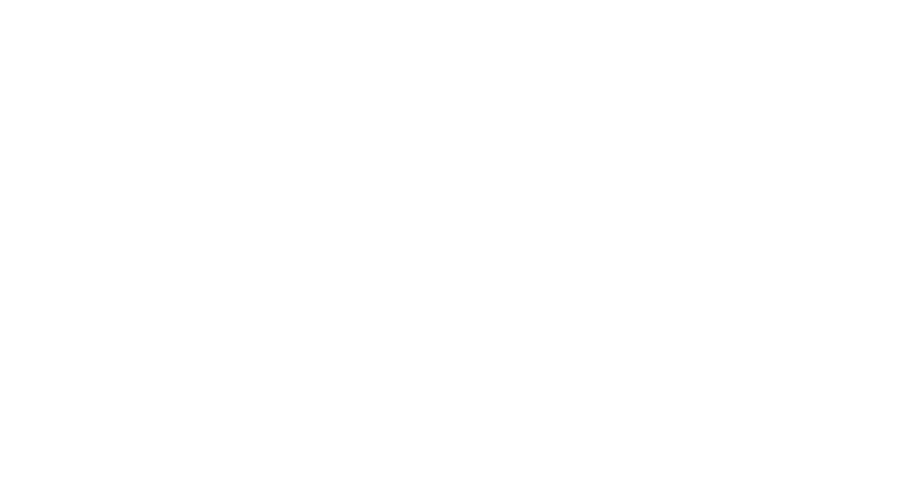

In [31]:
from drivers.prodriver import ProDriver

driver_name = 'SuchAPro'
driver = ProDriver(driver_name, allow_pitstops=False, weather_on=False)
driver.grip_fig = plt.figure(figsize=(9, 5))  # assigning a grip_fig will trigger the extra plot. Needs to be in cell before

In [32]:
season = Season(level=Level.Pro)
print('Running initial races...')
season.race(driver=driver, track_indices=range(3), use_weather=False) # Run a few races first to get our driver's eye in 
print('done.')

Running initial races...
done.


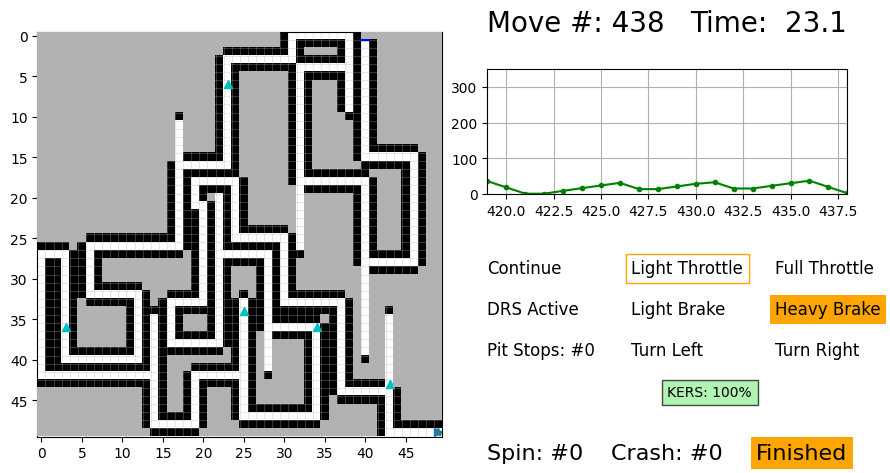

Opening DRS
Opening DRS
Chose not to open DRS
Opening DRS


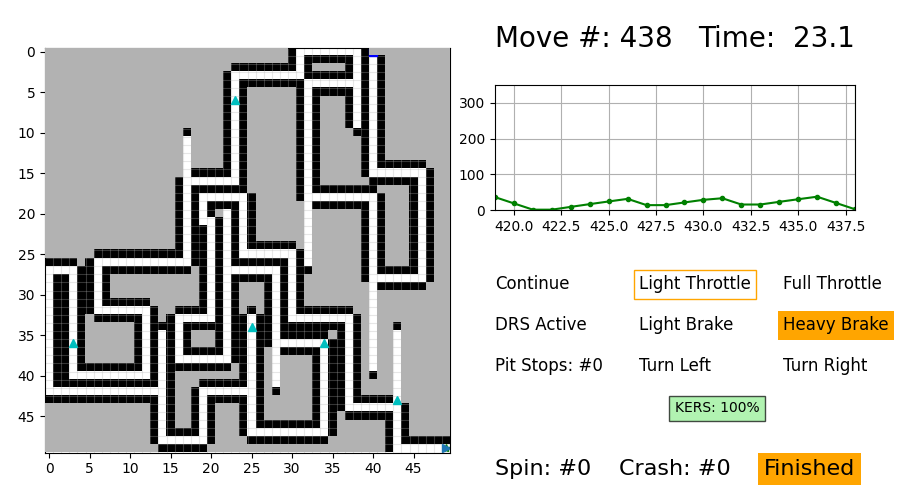

In [33]:
set_seed(0)
season.race(driver=driver, track_indices=[5], plot=True, use_safety_car=False, use_weather=False) 
plt.show()
plt.close()

### Changing tyres

Our driver loses so much time with worn out tyres! It's time to box for some new boots. At the start of each straight our driver AI runs two simulations to predict how long it would take to reach the end of the race with the current tyres versus a new set of tyres. At the start of each race the driver is told how many straights the track has and what their average length is. Our driver keeps track of how many straights we have driven down and so is able to guess at how long is left in the race. The AI can then use the tyre model it has learnt to predict how the tyres will degrade and the loss in race time that leads to, compared to resetting the tyre age to 0.

We can compare the estimated difference in race time to the cost of changing tyres - if the time gained from new tyres outweighs the time lost from pitting then the AI will bring the car to a halt and then issue the `ChangeTyres` action. We have hard coded a value of 3.0 for the 'pit loss', which roughly accounts for the turn when the car is brought to 0 speed, plus the turn waiting for new tyres, and then some further loss accelerating back to full speed. This kind of hardcoding is the antithesis of learning, however, so please do think how you could improve this! The forecasted tyre degradation is very uncertain at the start when we have very little data. This can lead to wildly varying grip estimates and the driver pitting very early. To counter this you could add in some measure of predictive uncertainty. For now we will force the driver to wait until it has seen some grip drop off before it can change tyres - again this is ugly and we rely on you to improve it!

One other factor to bear in mind is that it isn't necessarily the best strategy to immediately change tyres as soon as the race time gain outweighs the pit loss. This is for two reasons. Firstly, it might mean that the second stint is very long and we end up with very worn tyres towards the end of the race when there isn't enough time left in the race to make a second pitstop worth it. Secondly, if we always change tyres very early it means we will end up with a very limited set of data from which to build our tyre model. To tackle the second problem we have put a simple heuristic in place that prevents a pitstop until we have taken at least one tyre past the peak. This is hardly the ideal approach but we leave improving this and tackling the first problem up to you.

For now, let's enable pitstops and rerun that last race.

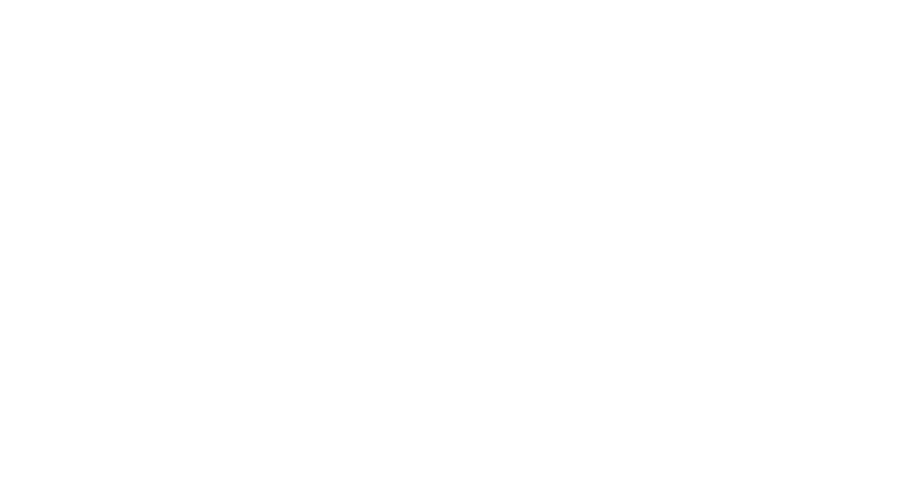

In [34]:
driver.allow_pitstops = True

driver.grip_fig = plt.figure(figsize=(9, 5))  # recreate so it plots below and not in cell above

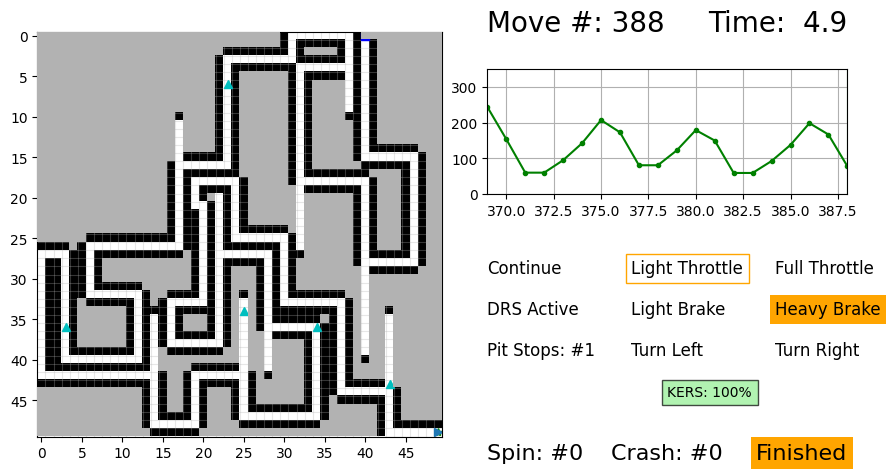

Opening DRS
Opening DRS
Box! Box! Box!


In [35]:
# Don't forget to run the cell above to create the figures each time before running this cell
set_seed(0)
season.race(driver=driver, track_indices=[5], plot=True, use_safety_car=False, use_weather=False)
plt.close()

We can see that the AI chose to change tyres part way through the race and completed the race with a better race time than it did before. This is the power of the pit stop!

### Choosing the tyre compound

Up until now we have been using just the Medium tyre, however the framework we have put in place for choosing whether to pit or not can also be used to decide which tyre to put on. The AI can simulate the race with each of the tyre compounds and then pick the compound that it thinks is the fastest option. Given much of the code is written for this already, we leave it up to you to implement if you want to. Getting the tyre choice right can have a big impact on your final race time. So if you want to win the Challenge then definitely focus some effort here! For now we will move on to rain.

# The weather and track grip

In F1 there are numerous factors that can affect the grip of the race track, for example the roughness of the tarmac or dust blown onto the circuit. However, there is nothing like some rain to add drama into an F1 race (ignoring the times it removes the race altogther). The weather has turned a race on its head on numerous occaisions, testing the skill of both the drivers and their strategists. Any driver challenging for the Championship title needs to learn to deal with a wet track and so, in our Maze Race, it is rain that the AI driver will have to deal with. 

Rain will reduce grip on track just as the tyres degrading does - track grip is an additonal multiplier on the speed delta, varying between 0 and 1 depending on how wet the track is. Unlike tyre grip, the AI isn't told what the track grip level is. This means there is a variable that will affect the car behaviour but, which the driver can't measure. In the field of AI/machine learning, this is called a *latent* (or *hidden*) variable. We can sketch out the situation as follows:

<img src="media/hidden_variables.PNG" alt="New speed with hidden variables" width="700">

We observe the current speed, the action we apply, and the resulting speed that the car reaches, as well as the tyre and aero grip. Previously (without the track grip variable in the frame) it was trivial to work out the speed delta variable by comparing the start speed with the new speed. This meant we could then learn the dynamics function. However, the new speed is now the product of two unknown variables, both of which are varying, which means we can't separate out the effect of the track grip from the car dynamics. We can show this by plotting an example car dynamics function with known and unknown grip levels:

In [36]:
# You don't need to run this if you ran it above. Repeated to save scrolling to the top if you restart the kernel.
from imports import *
%matplotlib widget

C:\Users\Anirbaan\AppData\Local\Temp\ipykernel_628\1272764082.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(9, 3))


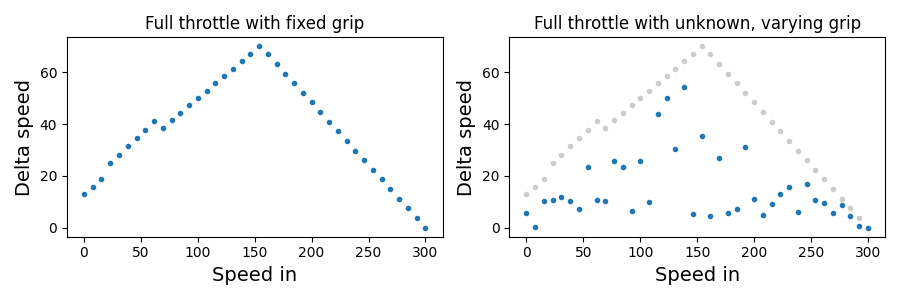

In [37]:
car = Car.get_car_for_level(Level.Pro)
set_seed(2)
speed_in = np.linspace(0, 300, 40)
speed_out = np.zeros_like(speed_in)
speed_out_unknown_grip = np.zeros_like(speed_in)
for i, s in enumerate(speed_in):
    speed_out[i] = car.dynamics_model.full_throttle(speed_in[i], grip_multiplier=1)
    speed_out_unknown_grip[i] = car.dynamics_model.full_throttle(speed_in[i], grip_multiplier=rng().rand())

fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(1, 2, 1)
ax.plot(speed_in, speed_out - speed_in, '.')
ax.set_xlabel('Speed in', fontsize=14)
ax.set_ylabel('Delta speed', fontsize=14)
ax.set_title('Full throttle with fixed grip')

ax = fig.add_subplot(1, 2, 2)
ax.plot(speed_in, speed_out - speed_in, '.', c=(0.8, 0.8, 0.8))
ax.plot(speed_in, speed_out_unknown_grip - speed_in, '.')
ax.set_xlabel('Speed in', fontsize=14)
ax.set_ylabel('Delta speed', fontsize=14)
ax.set_title('Full throttle with unknown, varying grip')
fig.tight_layout()



Clearly we can't just draw a line joining all the points when the grip is unknown, like we could for the plot on the left. We need some extra information to separate out the two unknown variables. One piece of information we have is that the unknown grip is limited to be between 0 and 1 and therefore the true dynamics function will be an upper bound on the observed data - i.e. the delta speed can only ever be reduced by track grip. This means we could use an algorithm such as 'alpha shapes', which can piece together an upper boundary over the points. However, this requires us to make an assumption about how smooth the true function is, which we don't really know (if you didn't have the grey dots to help you above, and had to draw an upper bound over the points, would you gamble that it was two straight lines or draw something that followed the bumps in the observed data points?). 

We are, in fact, going to take a much more blunt approach, and simply exclude any data point that we think might be rain-affected. This isn't totally straightforward as we don't know for sure when the track is fully dry. The AI is given the `WeatherState` data class each turn, which includes the current value for air temperature, track temperature, humidity, and rain intensity. However, grip is related to how wet the track is, which is more complex a variable than just the current rain intensity. This is because the water on track will build up as the rain falls and will remain on the track for several turns after it has finished raining as the track slowly dries out. To try and cover this off we will exclude all points during rain and for a fixed period afterwards, chosen, hopefully, to extend until the track is fully dry. This is clearly a wasteful and not particularly intelligent approach, one which you might like to improve upon.

Now we have a method in place to learn the car dynamics despite the rain, we can use the learnt dynamics function to estimate the previously unknown track grip level. That is, we use our dynamics model to predict what the car should have done in the dry, and then compare it to the actual observed delta speed. From this we can compute what the track grip must have been. This is actually not too dissimilar to what a real F1 driver does: compare the grip they are currently feeling on track to their knowledge of the car in the dry to assess just how wet the track is.

### Weather forecasting

At this point we have learnt the dynamics model and estimated the track grip for each data point we have observed. There is a small problem, however: we only estimate the track grip *after* we have taken an action and observed the response. This is not particularly helpful for choosing the action - is it still safe to accelerate or will we be going too fast to turn in the rain? We need a way of estimating the track grip before taking the action. Let's see if we can predict the track grip from the values in the `WeatherState`. For the purposes of this experimentation, we can take the data directly from the `WeatherStation`; during the race, of course, our AI will only have access to the data coming in turn-by-turn.

Let's have a look at some of the data first.

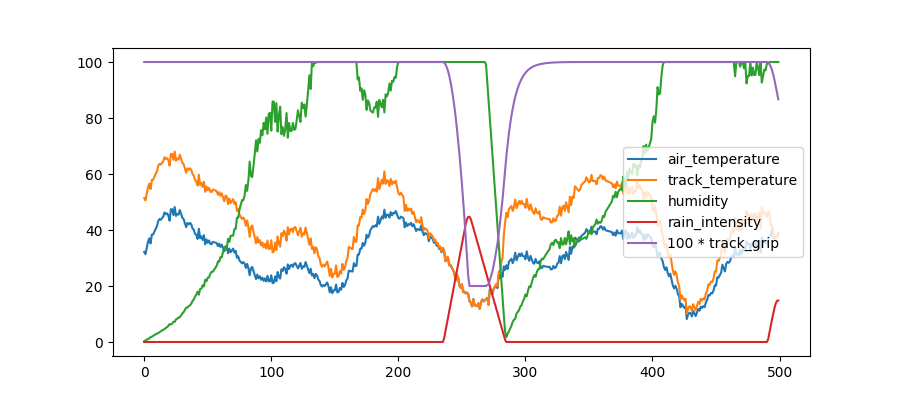

In [38]:
weather_station = WeatherStation()
plt.figure(figsize=(9, 4))
T = 500          # number of time points to plot
for name, data in weather_station.weather_data.items():
    plt.plot(data[:T], label=name)
plt.plot(100*weather_station.track_grip[:T], label='100 * track_grip')
plt.legend()

From first glance it certainly looks like there is plenty of structure there. Let's try a simple linear fit to track grip.

RMSE is 0.08, max error is 0.37


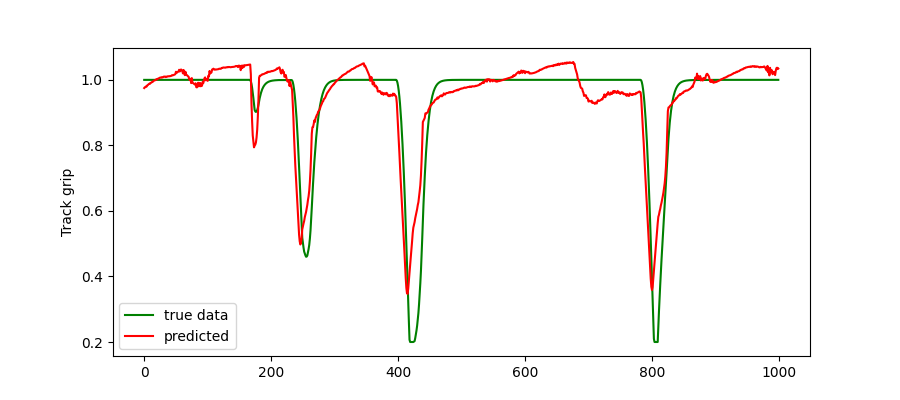

In [39]:
# **** This cell requires the previous cells in the weather forecasting section to run

from sklearn.linear_model import LinearRegression

# Stack each of the variables in the weather state (air temp, etc) into columns of an array
# Row t of X has the weather state data for time point t and y the track grip value for the same time point
X = np.hstack([data[:, None] for data in weather_station.weather_data.values()])
y = weather_station.track_grip[:, None]

# Fit the linear model from weather state to track grip
model = LinearRegression()
model.fit(X[:4000, :], y[:4000, :])                    # train on first 4000 points

# Make predictions and compute error
ys = model.predict(X[4000:, :])                        # test on remaining 1000 points
sq_err = (ys - y[4000:, :])**2
print(f'RMSE is {np.sqrt(np.mean(sq_err)):.2f}, max error is {np.sqrt(np.max(sq_err)):.2f}')

plt.figure(figsize=(9, 4))
plt.plot(y[4000:], 'g', label='true data')
plt.plot(ys, 'r', label='predicted')
plt.legend()
plt.ylabel('Track grip');

Well it is a reasonable first attempt but we miss the steep drops in grip, which are critical areas to predict if we want to avoid crashing. We could try a more complex model than linear but instead we should pick up on the comment earlier, which described how water on the track built up and then dried over time. This suggests that we can't just look at the current time point, we need to look at previous data as well because it will still be having an influence.

<img src="media/using_previous_time_steps.png" alt="Using previous time steps to predict track grip" width="600">

This brings us back to autoregressive models that we briefly mentioned earlier. These models are usually just linear models that use several previous steps worth of data to predict the next time point. Let's try it out - there is a helpful method in `ProDriver` that we can use.

RMSE is 0.002, max error is 0.04


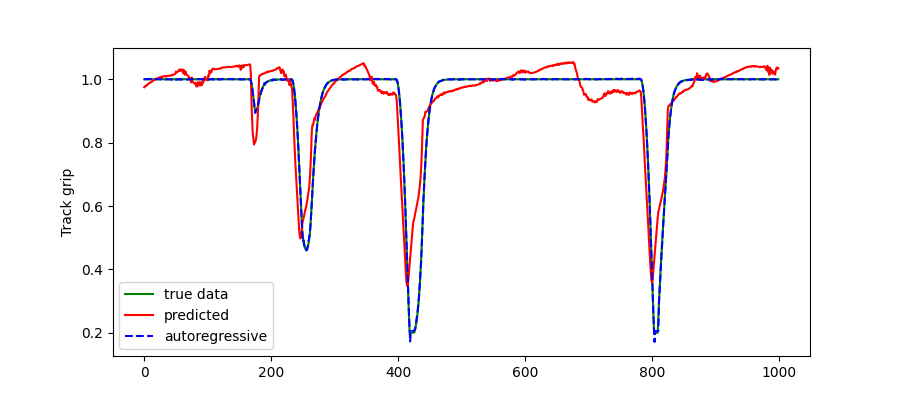

In [40]:
# **** This cell requires the previous cells in the weather forecasting section to run
num_previous_steps = 50

# Format the weather state (x) and track grip (y) data into arrays with format:
#     row t of inputs_y  = [ x_t, y_t-1, x_t-1, ..., y_t-num_previous_steps, x_t-num_previous_steps ]
#     row t of targets_y = [ y_t ]
inputs_y, targets_y = ProDriver.format_ar_arrays_for_y(X, y, num_previous_steps=num_previous_steps)

# Fit a linear model from inputs_y (previous x and y data) -> targets_y (current y)
model_y = LinearRegression().fit(inputs_y[:4000-num_previous_steps, :], targets_y[:4000-num_previous_steps, :])

# Make predictions. 
# Autoregressive arrays have the first num_previous_steps data points cut off so targets_y[0] = y[num_previous_steps]
ys_ar = model_y.predict(inputs_y[4000-num_previous_steps:, :])
sq_err = (ys_ar - y[4000:, :])**2
print(f'RMSE is {np.sqrt(np.mean(sq_err)):.3f}, max error is {np.sqrt(np.max(sq_err)):.2f}')

plt.figure(figsize=(9, 4))
plt.plot(y[4000:], 'g', label='true data')
plt.plot(ys, 'r', label='predicted')
plt.plot(ys_ar, 'b--', label='autoregressive');
plt.legend()
plt.ylabel('Track grip');

Wow that has made a big difference - can't even see the true data as the predicted line covers it so well. A lot of this comes from just having the previous track grip available - just predicting the previous state again for the next time step is a basic model that is often surprisingly effective! We do need to go one step further though: it is not good enough to just predict one-step-ahead, we need to predict the track grips all the way down the straight to the corner, so we can compute the target speeds. This is known as *multi-step* forecasting. There are two main approaches to doing this, usually termed the *direct* method and the *recursive* (or *iterative*) method. These are outlined in the diagram below. 

<img src="media/multi_step_forecasting.png" alt="Two approaches to multi-step forecasting" width="800">

The direct method trains a separate model to predict each future time point up to a predefined horizon. The recursive method still just makes a one-step-ahead prediction but then moves one step forward and uses the newly predicted value to predict the next value. In our case, as we have the weather data available as well we need two models: one to predict the track grip given the previous track grips and weather state up to the current time point, and one to predict the weather state at the next time point.

There are strengths and weaknesses of both approaches. The direct approach requires more data before it can be used as, if you want to predict the next 50 time points using the last 50 time points, you need 100 points of data to give you a single training data point. The recursive approach can suffer from serious stability problems, however. This is because each prediction is likely to have a small error in it and, as we use previous predictions to then make future predictions, these errors will keep building up until the model goes completely wrong.

We will implement the recursive approach here as it uses fewer data points and opens the door to building a full (nonlinear) state space model, which you might like to explore if you are interested! You could also implement the direct approach and see if that improves the predictions. To help with the forecast stability we will introduce bounds on the predicted weather state (all values lie between 0 and 100) and track grip (between 0 and 1). This prevents the predicitons wandering a long way off.

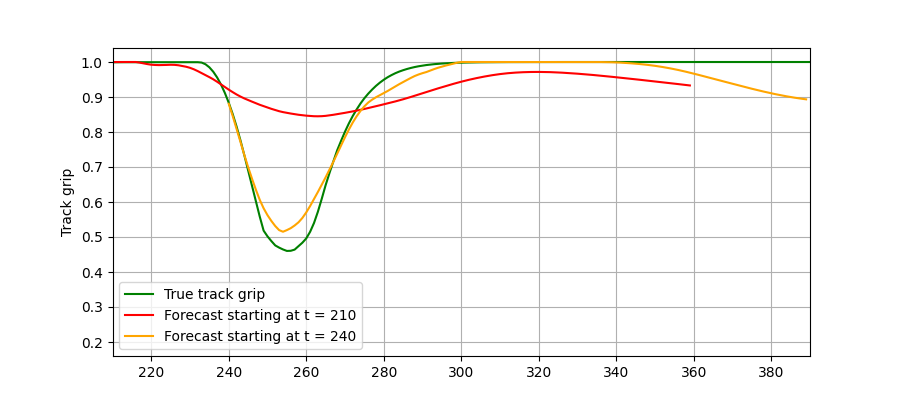

In [41]:
# **** This cell requires the previous cells in the weather forecasting section to run
# Fit a model to predict the weather state (x) at time t+1 given weather state and track grip up to time t
inputs_x, targets_x = ProDriver.format_ar_arrays_for_x(X, y, num_previous_steps=num_previous_steps)
model_x = LinearRegression().fit(inputs_x[:4000-num_previous_steps, :], targets_x[:4000-num_previous_steps, :])

# Forecast track grip by alternating predicitons of y_t and x_t+1
H = 150                   # number of steps to predict into the future
t0_1 = 210                # starting point for forecast
ys_1 = ProDriver.autoregressive_forecast(model_y=model_y, model_x=model_x, historic_x=X[:4000+t0_1, :], 
                                         historic_y=y[:4000+t0_1], current_x=X[4000+t0_1, :], num_forecast_steps=H, 
                                         bound_y=True, bound_x=True)

t0_2 = 240                # starting point for forecast
ys_2 = ProDriver.autoregressive_forecast(model_y=model_y, model_x=model_x, historic_x=X[:4000+t0_2, :], 
                                         historic_y=y[:4000+t0_2], current_x=X[4000+t0_2, :], num_forecast_steps=H, 
                                         bound_y=True, bound_x=True)

fig = plt.figure(figsize=(9, 4))
plt.plot(y[4000:], 'g', label='True track grip')
plt.plot(np.arange(t0_1, t0_1+H), ys_1, 'r', label=f'Forecast starting at t = {t0_1}')
plt.plot(np.arange(t0_2, t0_2+H), ys_2, 'orange', label=f'Forecast starting at t = {t0_2}')
plt.xlim(min(t0_1, t0_2), max(t0_1, t0_2) + H)
plt.grid()
plt.ylabel('Track grip')
plt.legend();

We can see how the model is able to predict the next few time steps quite accurately but that errors start to build up as the forecast gets further into the future. We can also see that the model predicts the loss in track grip from the rain better once the rain has started than from when it is still completely dry. The longest that we really need to forecast is around 20 steps as most straights are shorter than this. The plot above suggests that the model should be able to give us a reasonable accuracy over this time period. However, bear in mind that this model was trained on 4000 data points and our driver will have much less data than this for much of the Championship.

There are several things you could do to improve the weather forecasting, such as,
- try the direct approach rather than recursive one-step-ahead predictions
- try a nonlinear model such as a neural network (MLPRegressor from sklearn should be enough)
- investigate probabilistic models such that we can get error bands on the forecasts
- investigate state space models

You might also like to try some unsupervised learning on the weather data as it looks like there might be some low dimensional structure in the data that could be useful. 

For now, let's add in the track grip forecast, turn on the safety car, and try our driver out on the full challenge!

In [42]:
# Using the same driver from above - make sure you have run those cells!
driver.weather_on = True

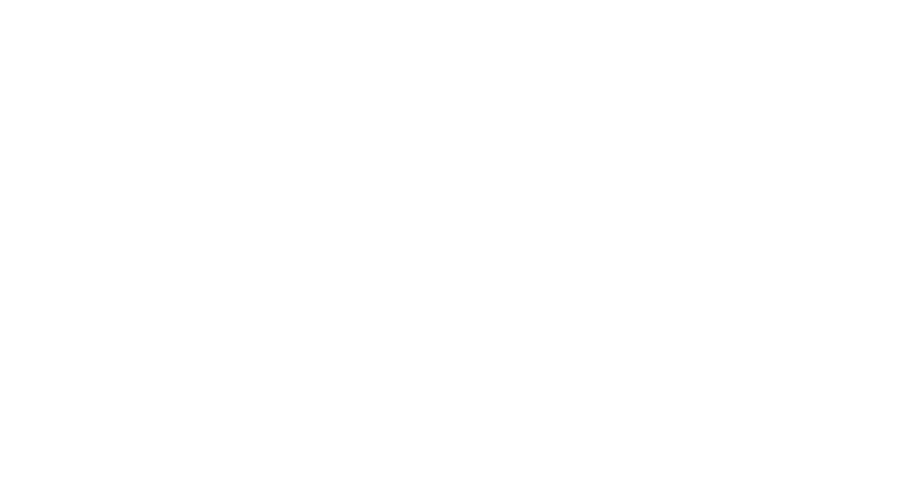

In [43]:
# Create figure placeholder
driver.grip_fig = plt.figure(figsize=(9, 5))       # assigning a grip_fig will trigger the extra plot

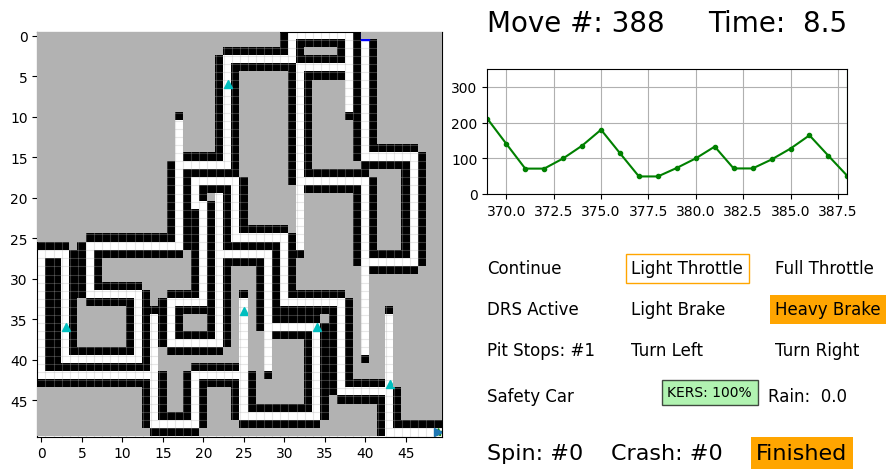

Safety car deployed for 15 turns at 100 speed
Opening DRS
Safety car no longer active
Safety car deployed for 12 turns at 135 speed
Safety car no longer active
Box! Box! Box!
Opening DRS
Safety car deployed for 9 turns at 173.5 speed
	Car speed of  217.0 exceeds safety car, penalty is now 1
Safety car speed estimate of  116.6 already below car speed of  269.4
	Increasing estimate of safety car speed to  218.0
	Car speed of  173.7 exceeds safety car, penalty is now 2
	Decreasing estimate of safety car speed to  103.0
	Increasing estimate of safety car speed to  174.7
Safety car no longer active


In [44]:
# Don't forget to re-run the cell above each time if you run this one more than once
print('Running initial races...')
season.race(driver=driver, track_indices=range(2))              # Run a few races first to get our driver's eye in 
print('done.')
set_seed(0)
season.race(driver=driver, track_indices=[5], plot=True)        # turn everything on!
plt.close()

# Congratulations! You have completed the McLaren Maze Race. 

You now have your very own Pro AI driver! There is plenty to do if you want to try and improve the AI - read back through the notebooks for levels 3 and 4 and pick one of the suggestions to tackle. If you want to submit your code to the online challenge then head back to the [McLaren Maze Race website](https://www.mclaren.com/mazerace).

## We would love to hear from you!

How did you find the whole Maze Race? What worked and what could be improved? [Please let us know by following this link.](https://forms.office.com/Pages/ResponsePage.aspx?id=1D5YJvyfwkadGvDKNaMKjclg_cyBBFJPg8x5VJ87DGJUNlNFTlVHS05LTUpKRk8xR04zOFVORFg3VS4u). 

We hope you have learnt a bit more about AT and Machine Learning and had some fun whilst doing it!

# Playground

In [3]:
from scipy.interpolate import interp1d, PchipInterpolator
from scipy.optimize import minimize
import scipy.linalg
from time import time as time_fn
from sklearn.linear_model import LinearRegression
import warnings
from matplotlib.ticker import MaxNLocator

from drivers.driver import *
from drivers.rookiedriver import RookieDriver


class MyProDriver(ProDriver):
    def __init__(self, name, weather_on=True, random_action_probability=0.5, random_action_decay=0.96,
                 min_random_action_probability=0.0, allow_pitstops=True, grip_fig=None, *args, **kwargs):

        super().__init__(name, weather_on, random_action_probability, random_action_decay,
                         min_random_action_probability, allow_pitstops, grip_fig, *args, **kwargs)


    def choose_tyres(self, track_info: TrackInfo) -> TyreChoice:
        # This method is called at the start of the race and whenever the driver chooses to make a pitstop. It needs to
        # return a TyreChoice enum

        # TODO: make an informed choice here!
        # self.current_tyre_choice = ...
        return super().choose_tyres(track_info)


    def make_a_move(self, car_state: CarState, track_state: TrackState, weather_state: WeatherState) -> Action:
        return super().make_a_move(car_state, track_state, weather_state)

    def update_with_action_results(self, previous_car_state: CarState, previous_track_state: TrackState,
                                   action: Action, new_car_state: CarState, new_track_state: TrackState,
                                   result: ActionResult, previous_weather_state: WeatherState):

        super().update_with_action_results(previous_car_state, previous_track_state, action, new_car_state, 
                                           new_track_state, result, previous_weather_state)



    def forecast_tyre_grip(self, tyre_ages, parameters=None):
        return super().forecast_tyre_grip(tyre_ages, parameters)


    def fit_tyre_model(self):
        super().fit_tyre_model()

    def should_we_change_tyres(self):
        return super.should_we_change_tyres()

    def fit_track_grip(self):
        super().fit_track_grip()

    def forecast_track_grip(self, current_weather_state: WeatherState, num_future_steps=0):
        # Predict current grip + num_future_steps into the future
        # Returns an array of length 1 + num_future_steps
        return super().forecast_track_grip(current_weather_state, num_future_steps)




In [6]:
import scipy

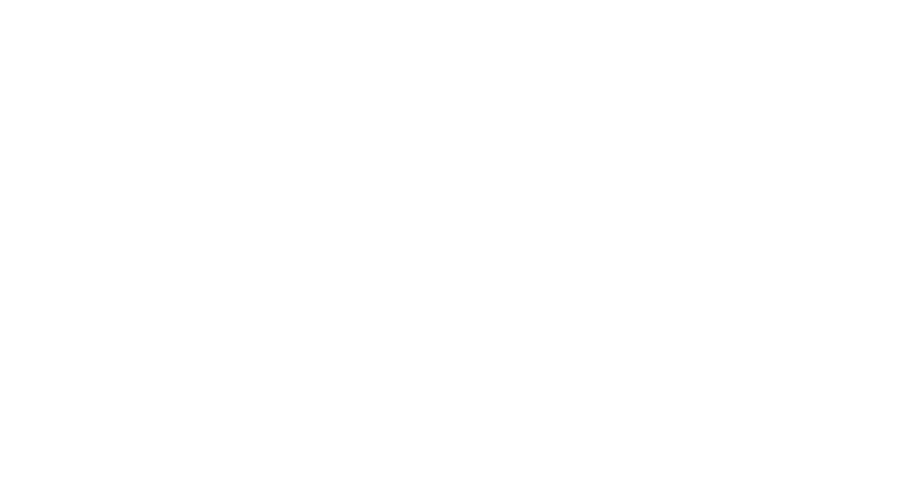

In [58]:
my_driver = MyProDriver('MyAI')

# Create figure placeholder
driver.grip_fig = plt.figure(figsize=(9, 5))       # assigning a grip_fig will trigger the extra plot

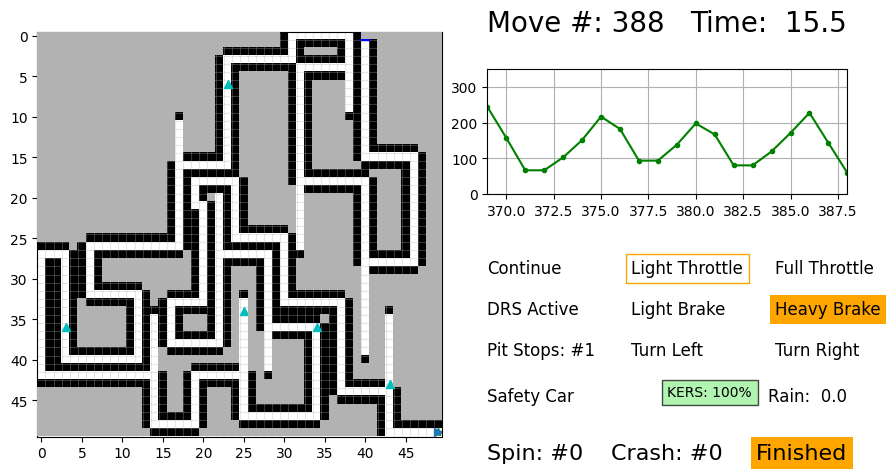

Safety car deployed for 15 turns at 100 speed
Opening DRS
Safety car no longer active
Safety car deployed for 12 turns at 135 speed
	Car speed of  135.4 exceeds safety car, penalty is now 1
	Decreasing estimate of safety car speed to  83.8
	Increasing estimate of safety car speed to  136.4
Safety car no longer active
Opening DRS
Box! Box! Box!
Safety car deployed for 9 turns at 173.5 speed
	Increasing estimate of safety car speed to  250.3
	Car speed of  235.4 exceeds safety car, penalty is now 2
	Decreasing estimate of safety car speed to  148.5
	Increasing estimate of safety car speed to  236.4
	Car speed of  198.4 exceeds safety car, penalty is now 3
	Decreasing estimate of safety car speed to  119.8
	Increasing estimate of safety car speed to  199.4
	Car speed of  190.9 exceeds safety car, penalty is now 4
	Decreasing estimate of safety car speed to  160.4
	Increasing estimate of safety car speed to  191.9
Safety car no longer active


In [59]:
# Don't forget to re-run the cell above each time if you run this one more than once
print('Running initial races...')
season.race(driver=driver, track_indices=range(2))              # Run a few races first to get our driver's eye in 
print('done.')
set_seed(0)
season.race(driver=driver, track_indices=[5], plot=True)        # turn everything on!
plt.close()

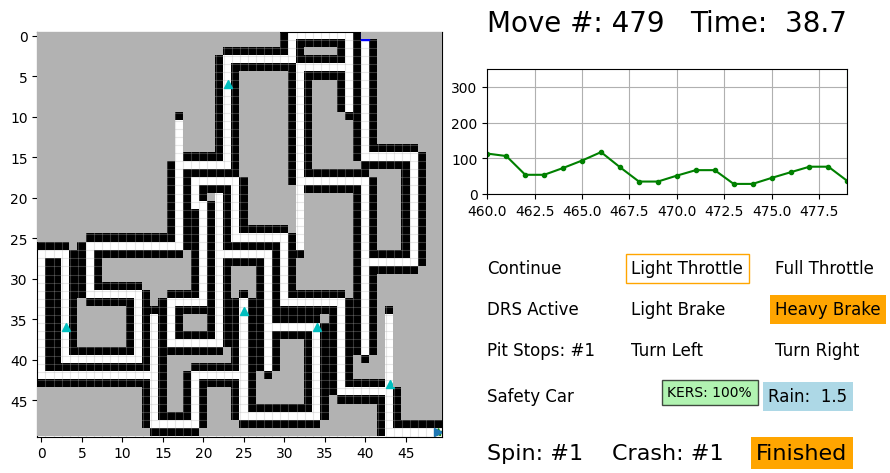

	Crashed! We targeted 25 speed but were going  34. We thought we would be going 34 using a grip of 0.27.DRS was not active this straight.
Safety car deployed for 15 turns at 100 speed
Safety car no longer active
Safety car deployed for 12 turns at 135 speed
Safety car no longer active
Opening DRS
Box! Box! Box!
Opening DRS
Safety car deployed for 9 turns at 173.5 speed
	Car speed of  264.5 exceeds safety car, penalty is now 1
Safety car speed estimate of  110.0 already below car speed of  294.1
	Car speed of  214.8 exceeds safety car, penalty is now 2
Safety car speed estimate of  110.0 already below car speed of  264.5
	Increasing estimate of safety car speed to  215.8
	Car speed of  183.9 exceeds safety car, penalty is now 3
	Decreasing estimate of safety car speed to  114.8
	Increasing estimate of safety car speed to  184.9
Safety car no longer active
Chose not to open DRS
Opening DRS


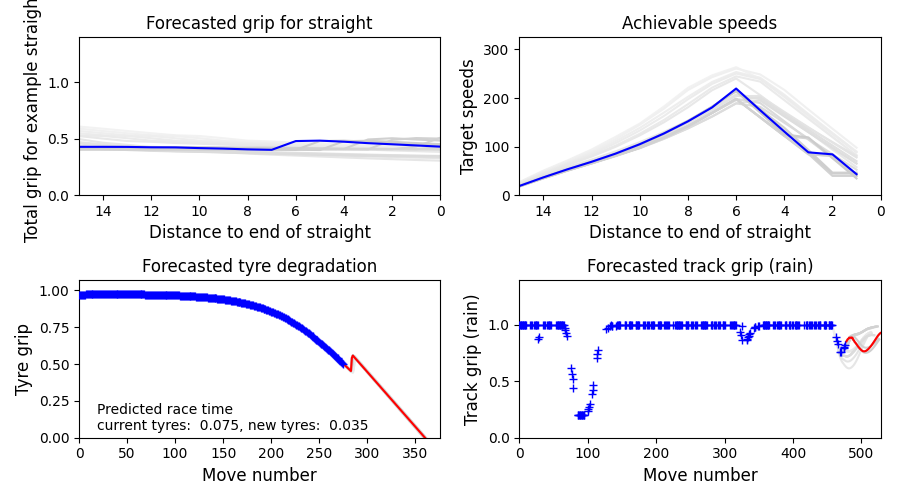

In [10]:
# Initialize ProDriver with all features
driver = ProDriver('FullFeatures')

# Create visualization figures
driver.grip_fig = plt.figure(figsize=(9, 5))

# First run - training races
print('Running initial training races...')
season = Season(level=Level.Pro)
season.race(
    driver=driver, 
    track_indices=range(2),    # First two tracks for training
)
print('Training complete.')

# Main race with visualization
print('\nStarting main race with all features...')
set_seed(0)  # For reproducibility
season.race(
    driver=driver, 
    track_indices=[5],        # Using built-in track #5
    plot=True,               # Enable visualization
)
plt.close()